## RNN Model for crash prediction
### Developed by: bpben

In [3]:
import re
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import describe

In [4]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
import sys
sys.path.append('/Users/B/Documents')

### Data processing
The approach here is to create 3 time-lag features:

1. crashes in the past week
2. crashes in the past month
3. crashes in the past quarter (three months)
4. average crashes per week up to target week

All features except 4 are calculated to exclude one another.  That is, crashes in the past month does not include the past week's crashes.  Crashes in the past quarter do not include the past month.

In [6]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [8]:
# Read in data
data = pd.read_csv('../data/boston/processed/vz_predict_dataset.csv.gz', 
                   compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'year','week'], inplace=True)

IOError: [Errno 2] No such file or directory: '../data/boston/processed/vz_predict_dataset.csv.gz'

In [ ]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [ ]:
# scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_nonzero[SEG_CHARS] = scaler.fit_transform(data_nonzero[SEG_CHARS])
data_nonzero['target'] = (data['crash']>0).astype(int)
data_model = data_nonzero[['target']+SEG_CHARS].values

In [55]:
pct_train = .7
#train_segments = data_nonzero.segment_id.unique()[:int(len(data_nonzero.segment_id.unique())*pct_train)]
segment_ids = data_nonzero.segment_id.unique()
inds = np.arange(0.0,len(segment_ids)) / len(segment_ids) < pct_train
train_ids = segment_ids[inds]
test_ids = segment_ids[~inds]

In [68]:
# split into train and test sets
train_size = int(len(data_model) * 0.67)
test_size = len(data_model) - train_size
#train, test = data_model[0:train_size,:], data_model[train_size:len(data_model),:]
train = data_nonzero[data_nonzero.segment_id.isin(train_ids)][['target']+SEG_CHARS].values
test = data_nonzero[data_nonzero.segment_id.isin(test_ids)][['target']+SEG_CHARS].values
print(len(train), len(test))

(302720, 129664)


In [69]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [70]:
look_back = 12
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [71]:
# class_weight
neg, pos = data_nonzero.target.value_counts(normalize=True)
class_weight = {0: 1/neg, 1: 1/pos}

In [72]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

In [73]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=trainX.shape[1:]))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY,
          validation_data=(testX, testY),
          epochs=50, batch_size=1000, 
          class_weight = class_weight,
          verbose=2)

Train on 302707 samples, validate on 129651 samples
Epoch 1/50
16s - loss: 1.3408 - acc: 0.8211 - val_loss: 0.6671 - val_acc: 0.6884
Epoch 2/50
15s - loss: 1.3368 - acc: 0.7770 - val_loss: 0.6610 - val_acc: 0.8151
Epoch 3/50
16s - loss: 1.3352 - acc: 0.7623 - val_loss: 0.6471 - val_acc: 0.9624
Epoch 4/50
15s - loss: 1.3335 - acc: 0.9260 - val_loss: 0.6621 - val_acc: 0.9124
Epoch 5/50
15s - loss: 1.3334 - acc: 0.8264 - val_loss: 0.6625 - val_acc: 0.9523
Epoch 6/50
15s - loss: 1.3335 - acc: 0.9180 - val_loss: 0.6727 - val_acc: 0.8858
Epoch 7/50
16s - loss: 1.3329 - acc: 0.9175 - val_loss: 0.6495 - val_acc: 0.9865
Epoch 8/50
15s - loss: 1.3320 - acc: 0.9465 - val_loss: 0.6702 - val_acc: 0.9503
Epoch 9/50
15s - loss: 1.3319 - acc: 0.9267 - val_loss: 0.6568 - val_acc: 0.9845
Epoch 10/50
15s - loss: 1.3314 - acc: 0.8380 - val_loss: 0.6414 - val_acc: 0.9941
Epoch 11/50
15s - loss: 1.3310 - acc: 0.9735 - val_loss: 0.6568 - val_acc: 0.9875
Epoch 12/50
15s - loss: 1.3312 - acc: 0.9658 - val_loss

In [74]:
# make predictions
#trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [75]:
from sklearn.metrics import roc_auc_score

In [76]:
roc_auc_score(testY, testPredict)

0.46776660379990886

In [23]:
a = testY.reshape(-1, 1) - testPredict

In [24]:
np.sum(testY - np.reshape(testPredict, (a.shape[0],)))

-65813.131162494421

In [ ]:
np.sum(testY - np.reshape(testPredict, (a.shape[0],)))

In [28]:
pd.Series(testPredict.flatten()).value_counts()

0.474611    7404
0.473700    6108
0.472609    4797
0.463795    2808
0.463918    1989
0.461656    1521
0.463456    1287
0.484162    1170
0.469727    1053
0.471350    1053
0.482619     936
0.470984     819
0.480933     702
0.471984     586
0.469841     585
0.468830     585
0.462914     585
0.470529     585
0.446409     479
0.456383     468
0.471074     468
0.455106     468
0.470379     468
0.468929     468
0.443561     468
0.436578     468
0.461401     468
0.449788     468
0.454803     468
0.468985     362
            ... 
0.468935       1
0.468935       1
0.468934       1
0.468932       1
0.468931       1
0.468931       1
0.468930       1
0.468950       1
0.468951       1
0.468979       1
0.468966       1
0.468977       1
0.468974       1
0.468972       1
0.468971       1
0.468969       1
0.468969       1
0.468969       1
0.468967       1
0.468963       1
0.468951       1
0.468963       1
0.468963       1
0.468962       1
0.468957       1
0.468957       1
0.468955       1
0.468955      

0

In [174]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: non-broadcastable output operand with shape (70236,1) doesn't match the broadcast shape (70236,6)

In [66]:
#Parameters for model
#Model parameters
params = dict()

#cv parameters
cvp = dict()
cvp['pmetric'] = 'roc_auc'
cvp['iter'] = 5 #number of iterations
cvp['folds'] = 5 #folds for cv (default)

#LR parameters
mp = dict()
mp['LogisticRegression'] = dict()
mp['LogisticRegression']['penalty'] = ['l1','l2']
mp['LogisticRegression']['C'] = ss.beta(a=5,b=2) #beta distribution for selecting reg strength

#RF model parameters
mp['RandomForestClassifier'] = dict()
mp['RandomForestClassifier']['n_estimators'] = [2**8] #number of trees in the forest
mp['RandomForestClassifier']['max_features'] = ss.beta(a=5,b=2) #number of features at split
mp['RandomForestClassifier']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create

In [67]:
# Features
features = [u'pre_week', u'pre_month', u'pre_quarter', 'avg_week', u'AADT', u'SPEEDLIMIT',
       u'Struct_Cnd', u'Surface_Tp', u'F_F_Class']

In [68]:
#Initialize tuner
tune = Tuner(df)

In [69]:
#Base RF model
tune.tune('RF_base', 'RandomForestClassifier', features, cvp, mp['RandomForestClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   27.3s finished


In [70]:
#Base LR model
tune.tune('LR_base', 'LogisticRegression', features, cvp, mp['LogisticRegression'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


In [71]:
#Display results
tune.grid_results

,mean_test_score,mean_train_score,params,name,m_name
0,0.760451,0.995825,"{u'max_features': 0.667813283122, u'max_leaf_n...",RF_base,RandomForestClassifier
1,0.760839,0.995798,"{u'max_features': 0.736051950141, u'max_leaf_n...",RF_base,RandomForestClassifier
2,0.759570,0.995734,"{u'max_features': 0.754430216885, u'max_leaf_n...",RF_base,RandomForestClassifier
3,0.721338,0.995814,"{u'max_features': 0.880590604518, u'max_leaf_n...",RF_base,RandomForestClassifier
4,0.733999,0.995845,"{u'max_features': 0.867849733882, u'max_leaf_n...",RF_base,RandomForestClassifier
0,0.516315,0.559762,"{u'penalty': u'l2', u'C': 0.868912981911}",LR_base,LogisticRegression
1,0.516315,0.559733,"{u'penalty': u'l2', u'C': 0.821272193817}",LR_base,LogisticRegression
2,0.516440,0.559701,"{u'penalty': u'l2', u'C': 0.686060522494}",LR_base,LogisticRegression
3,0.516315,0.559762,"{u'penalty': u'l2', u'C': 0.88118343688}",LR_base,LogisticRegression
4,0.516440,0.559604,"{u'penalty': u'l2', u'C': 0.607598491451}",LR_base,LogisticRegression


In [84]:
# Run test
test = Tester(df)
test.init_tuned(tune)
test.run_tuned('RF_base', cal=False)

Fitting RF_base model with 9 features
f1_score:  0.153846153846
brier_score:  0.0316728329575


### Lift chart by "risk bin"
The classifier problem is difficult because the classes are unbalanced (.05% have crashes at target week).  More useful are the probabilities being produced by the model, which give some idea of risk.

In [85]:
def lift_chart(x_col, y_col, data, ax=None):

    p = sns.barplot(x=x_col, y=y_col, data=data, 
                    palette='Reds', ax = None, ci=None)
    vals = p.get_yticks()
    p.set_yticklabels(['{:3.0f}%'.format(i*100) for i in vals])
    xvals = [x.get_text().split(',')[-1].strip(']') for x in p.get_xticklabels()]
    xvals = ['{:3.0f}%'.format(float(x)*100) for x in xvals]
    p.set_xticklabels(xvals)
    p.set_axis_bgcolor('white')
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_title('Predicted probability vs actual percent')
    return(p)
    
def density(data, score, ax=None):
    p = sns.kdeplot(risk_df['risk_score'], ax=ax)
    p.set_axis_bgcolor('white')
    p.legend('')
    p.set_xlabel('Predicted probability of crash')
    p.set_title('KDE plot predictions')
    return(p)

In [103]:
risk_scores = test.rundict['RF_base']['m_fit'].predict_proba(test.data.test_x[features])[:,1]
risk_df = pd.DataFrame({'risk_score':risk_scores, 'crash':test.data.test_y})
print risk_df.risk_score.describe()
risk_df['categories'] = pd.cut(risk_df['risk_score'], bins=[-1, 0, .01, .02, .05, max(risk_scores)])
risk_mean = risk_df.groupby('categories')['crash'].count()
print risk_mean

count    619.000000
mean       0.028900
std        0.106733
min        0.000000
25%        0.000000
50%        0.000000
75%        0.003906
max        0.867188
Name: risk_score, dtype: float64
categories
(-1, 0]          427
(0, 0.01]         58
(0.01, 0.02]      60
(0.02, 0.05]      13
(0.05, 0.867]     61
Name: crash, dtype: int64


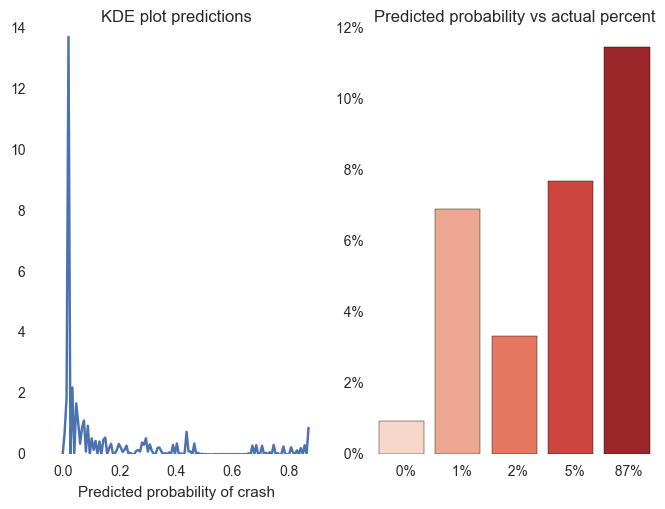

In [104]:
fig, axes = plt.subplots(1, 2)
lift_chart('categories', 'crash', risk_df, 
           ax=axes[1])
density(risk_df, 'risk_score', ax=axes[0])

In [105]:
# output predictions
# predict on all segments
data_model['risk_score'] = test.rundict['RF_base']['m_fit'].predict_proba(data_model[features])[:,1]
data_model.to_csv('seg_with_risk_score.csv', index=False)

### Check sensitivity to week
I predicted an arbitrary week as target here, but I'd like to see whether things change significantly if I change that week.  A good metric to measure that is brier score loss.  It'll be low throughout as the classifier doesn't perform great, but it shouldn't vary a huge amount.

In [106]:
for w in [20, 30, 40, 50]:
    print "week ", w
    crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','week']), 'crash', w)
    data_model = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')
    df = Indata(data_model, 'target')
    # create train/test split
    df.tr_te_split(.7)
    test = Tester(df)
    test.init_tuned(tune)
    test.run_tuned('RF_base', cal=False)
    print '\n'

week  20
Train obs: 1360
Test obs: 618
Fitting RF_base model with 9 features
f1_score:  0.1
brier_score:  0.0292948065731


week  30
Train obs: 1374
Test obs: 604
Fitting RF_base model with 9 features
f1_score:  0.0
brier_score:  0.0393970488434


week  40
Train obs: 1396
Test obs: 582
Fitting RF_base model with 9 features
f1_score:  0.0
brier_score:  0.0384830758081


week  50
Train obs: 1410
Test obs: 568
Fitting RF_base model with 9 features
f1_score:  0.0952380952381
brier_score:  0.0312575867277


